<h1 style="text-align:center; background-color:#2C3E50; color:white; padding:20px; border-radius:10px;">
📊 Análisis de Retención de Clientes por Cohortes
</h1>

<h2 style="background-color:#1abc9c; color:white; padding:10px; border-radius:6px;">
📘 Introducción
</h2>

<p style="font-size:15px; line-height:1.6;">
Este análisis tiene como objetivo evaluar la <strong>retención de clientes a lo largo del tiempo</strong> mediante una segmentación por <strong>cohortes de adquisición</strong>. Para ello, se utilizan datos de ventas históricas en línea, agrupando a los clientes según el mes en que realizaron su primera compra y analizando su comportamiento en los meses siguientes.
</p>

<p style="font-size:15px; line-height:1.6;">
El proceso incluye la limpieza y transformación de los datos, la creación de variables de cohorte, el cálculo del índice de permanencia por cliente, y la construcción de una matriz de retención. Finalmente, los resultados se visualizan mediante un <strong>heatmap</strong> que permite identificar patrones de fidelización, caídas en la retención y oportunidades de mejora en la relación con los clientes.
</p>

<p style="font-size:15px; line-height:1.6;">
Este tipo de análisis es especialmente útil para áreas de <strong>marketing, producto y estrategia comercial</strong>, ya que proporciona información clave para la toma de decisiones orientadas a mejorar la experiencia del cliente y aumentar su ciclo de vida.
</p>


<h2 style="background-color:#3498db; color:white; padding:10px; border-radius:6px;">
1. 📥 Cargar y limpiar los datos
</h2>


In [155]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar archivo Parquet con datos de ventas online
data = pd.read_parquet('../../datasets/online_retail.parquet')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2023-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2023-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2023-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2023-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2023-12-01 08:26:00,3.39,17850.0,United Kingdom


In [156]:
# Crear una copia del DataFrame orginal para trabajar
df = data.copy()

# Aplicar filtros para limpiar los datos:
# - Excluir facturas que comienzan con letras (posibles anulaciones o notas de crédito)
# - Incluir solo registros con CustomerID válido (no nulo)
# - Incluir solo cantidades y precios mayores a 0
mask = (
    (~df['InvoiceNo'].str.match(r'^[A-Za-z]'))
    & (df['CustomerID'].notna())
    & (df['Quantity'] > 0)
    & (df['UnitPrice'] > 0)
)
df = df.loc[mask]

# Eliminar duplicados para evitar conteos repetidos
df = (df.drop_duplicates(
        subset=['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate']
        ).reset_index(drop=True)
)
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
365845,578849,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,2,2024-11-27 10:39:00,2.95,13232.0,United Kingdom
114055,551270,22346,PARTY PIZZA DISH GREEN POLKADOT,6,2024-04-27 12:35:00,0.85,15891.0,United Kingdom
129194,553189,22620,4 TRADITIONAL SPINNING TOPS,3,2024-05-15 13:14:00,1.45,15033.0,United Kingdom
115610,551471,20728,LUNCH BAG CARS BLUE,1,2024-04-28 16:40:00,1.65,16370.0,United Kingdom
8670,537382,35953,FOLKART STAR CHRISTMAS DECORATIONS,1,2023-12-06 13:13:00,1.25,16710.0,United Kingdom


<h2 style="background-color:#2ecc71; color:white; padding:10px; border-radius:6px;">
2. 🧩 Crear variables de cohorte
</h2>

In [157]:
# Extraer el mes de cada factura
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Identificar el primer mes de compra (cohorte) para cada cliente
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
59172,544455,22443,GROW YOUR OWN HERBS SET OF 3,1,2024-02-20 13:18:00,7.95,13097.0,United Kingdom,2024-02,2023-12
83112,547240,21982,PACK OF 12 SUKI TISSUES,2,2024-03-21 16:32:00,0.29,17585.0,United Kingdom,2024-03,2024-01
337113,576065,20724,RED RETROSPOT CHARLOTTE BAG,6,2024-11-13 15:42:00,0.85,15005.0,United Kingdom,2024-11,2023-12
200053,562213,23203,JUMBO BAG DOILEY PATTERNS,4,2024-08-03 13:39:00,2.08,13975.0,United Kingdom,2024-08,2024-03
392351,581502,22573,STAR WOODEN CHRISTMAS DECORATION,8,2024-12-09 10:51:00,0.85,15910.0,United Kingdom,2024-12,2024-01


<h2 style="background-color:#f1c40f; color:#2c3e50; padding:10px; border-radius:6px;">
3. 📆 Calcular índice de cohorte
</h2>

In [158]:
# Calcular cuántos meses han pasado desde la primera compra
# Nota: se usa .apply(lambda x: x.n) porque el resultado es un objeto de tipo Period
df['CohortIndex'] = (df['InvoiceMonth'] - df['CohortMonth']).apply(lambda x: x.n)
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
118426,551946,22501,PICNIC BASKET WICKER LARGE,16,2024-05-05 11:18:00,8.50,18229.0,United Kingdom,2024-05,2023-12,5
309399,573373,22812,PACK 3 BOXES CHRISTMAS PANNETONE,2,2024-10-30 13:37:00,1.95,14684.0,United Kingdom,2024-10,2023-12,10
180298,559895,22412,METAL SIGN NEIGHBOURHOOD WITCH,12,2024-07-13 12:06:00,2.10,14110.0,United Kingdom,2024-07,2024-03,4
207545,563076,22078,RIBBON REEL LACE DESIGN,120,2024-08-11 16:12:00,1.85,14646.0,Netherlands,2024-08,2023-12,8
186596,560590,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2024-07-19 15:55:00,0.65,12560.0,Germany,2024-07,2024-07,0


<h2 style="background-color:#9b59b6; color:white; padding:10px; border-radius:6px;">
4. 📊 Construir la matriz de cohortes
</h2>

In [159]:
# Contar la cantidad de clientes únicos por cohorte y mes
cohort_data = df.groupby(
    by=['CohortMonth', 'CohortIndex']
)['CustomerID'].nunique().reset_index()

# Convertir a formato de matriz (cohortes en filas, meses en columnas)
cohort_pivot = cohort_data.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='CustomerID'
)
cohort_pivot

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2023-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2024-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2024-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2024-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2024-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2024-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2024-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2 style="background-color:#e67e22; color:white; padding:10px; border-radius:6px;">
5. 📈 Calcular la tasa de retención
</h2>

In [160]:
# Obtener el tamaño de cada cohorte (columna 0)
cohort_sizes = cohort_pivot[0]

# Dividir cada fila entre el valor del mes 0 para normalizar (retención)
retention = cohort_pivot.divide(cohort_sizes, axis=0).round(4)
retention

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2023-12,1.0,0.3661,0.3232,0.3842,0.3627,0.3977,0.3627,0.3492,0.3537,0.3955,0.3740,0.5028,0.2655
2024-01,1.0,0.2206,0.2662,0.2302,0.3213,0.2878,0.2470,0.2422,0.2998,0.3261,0.3645,0.1175,NaN
2024-02,1.0,0.1868,0.1868,0.2842,0.2711,0.2474,0.2526,0.2789,0.2474,0.3053,0.0684,NaN,NaN
2024-03,1.0,0.1504,0.2522,0.1991,0.2235,0.1681,0.2677,0.2301,0.2788,0.0863,NaN,NaN,NaN
2024-04,1.0,0.2133,0.2033,0.2100,0.1967,0.2267,0.2167,0.2600,0.0733,NaN,NaN,NaN,NaN
2024-05,1.0,0.1901,0.1725,0.1725,0.2077,0.2324,0.2641,0.0951,NaN,NaN,NaN,NaN,NaN
2024-06,1.0,0.1736,0.1570,0.2645,0.2314,0.3347,0.0950,NaN,NaN,NaN,NaN,NaN,NaN
2024-07,1.0,0.1809,0.2074,0.2234,0.2713,0.1117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,1.0,0.2071,0.2485,0.2426,0.1243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2 style="background-color:#34495e; color:white; padding:10px; border-radius:6px;">
6. 🖼️ Visualizar la matriz de retención
</h2>

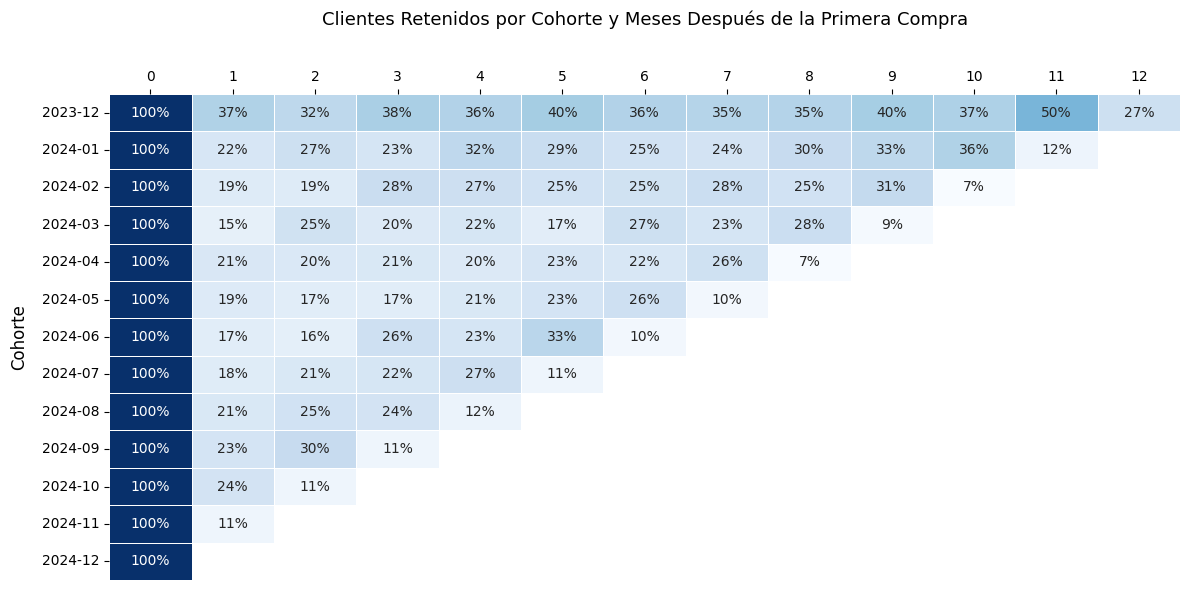

In [161]:
# Crear el gráfico de calor (heatmap)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    retention,
    annot=True,             # Mostrar valores dentro de cada celda
    fmt='.0%',              # Formato porcentaje sin decimales
    cmap='Blues',           # Colores en escala azul
    cbar=False,             # Ocultar barra de color
    linewidths=0.5,         # Líneas internas
    linecolor='white'
)

# Mover las etiquetas del eje X a la parte superior del gráfico
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Título y etiquetas
plt.title('Clientes Retenidos por Cohorte y Meses Después de la Primera Compra', fontsize=13, pad=50)
plt.ylabel('Cohorte', fontsize=12, labelpad=10)
plt.xlabel('', fontsize=12, labelpad=10)  # Vacío para evitar mostrar texto innecesario

# Ajustar espaciado automático
plt.tight_layout()

# Mostrar el gráfico final
plt.show()

<h2 style="background-color:#34495e; color:white; padding:10px; border-radius:6px;">
🔍 Conclusiones Principales
</h2>

<h3 style="color:#2c3e50;">📉 Caída Inicial en la Retención:</h3>
<p>
En todas las cohortes, se observa una caída significativa en la retención después del primer mes (mes 1). Por ejemplo:
<ul>
  <li><b>Cohorte 2023-12:</b> baja de <b>100%</b> en el mes 0 a <b>37%</b> en el mes 1.</li>
  <li><b>Cohorte 2024-03:</b> disminuye de <b>100%</b> a <b>15%</b> en el mes 1.</li>
</ul>
Este patrón sugiere que una gran proporción de clientes no realiza compras repetidas inmediatamente después de su primera compra.
</p>

<h3 style="color:#2c3e50;">📊 Estabilización con Fluctuaciones:</h3>
<p>
Después de la caída inicial, las tasas de retención tienden a estabilizarse o fluctúan en los meses siguientes, generalmente entre el <b>20%</b> y <b>40%</b>. Por ejemplo:
<ul>
  <li><b>Cohorte 2023-12:</b> varía entre <b>32%</b> y <b>50%</b> hasta el mes 11, con una caída a <b>27%</b> en el mes 12.</li>
  <li><b>Cohorte 2024-01:</b> fluctúa entre <b>22%</b> y <b>36%</b> hasta el mes 10, cayendo a <b>12%</b> en el mes 11.</li>
</ul>
Esto indica que un grupo más pequeño de clientes permanece activo con compras intermitentes.
</p>

<h3 style="color:#2c3e50;">📅 Efecto Estacional:</h3>
<p>
Se observa un pico de retención en noviembre, probablemente relacionado con compras navideñas:
<ul>
  <li><b>Cohorte 2023-12, mes 11:</b> 50%</li>
  <li><b>Cohorte 2024-01, mes 10:</b> 36%</li>
  <li><b>Cohorte 2024-02, mes 9:</b> 31%</li>
</ul>
Sin embargo, en diciembre (el mes siguiente), las tasas suelen caer:
<ul>
  <li><b>Cohorte 2023-12, mes 12:</b> 27%</li>
  <li><b>Cohorte 2024-01, mes 11:</b> 12%</li>
</ul>
Esto sugiere que <b>noviembre</b> es un mes clave, mientras que <b>diciembre</b> podría reflejar menor actividad post-temporada alta.
</p>

<h3 style="color:#2c3e50;">💎 Mayor Retención en Cohortes Antiguas:</h3>
<p>
Clientes de cohortes más antiguas muestran mayor retención en meses clave como noviembre:
<ul>
  <li><b>Cohorte 2023-12 (mes 11):</b> 50%</li>
  <li><b>Cohorte 2024-01 (mes 10):</b> 36%</li>
  <li><b>Cohorte 2024-02 (mes 9):</b> 31%</li>
  <li><b>Cohorte 2024-03 (mes 8):</b> 28%</li>
</ul>
Esto podría sugerir un efecto de lealtad o hábito.
</p>

<h3 style="color:#2c3e50;">📉 Tasas de Retención Generalmente Bajas:</h3>
<p>
La mayoría de las tasas se mantienen por debajo del 40%. Ejemplos:
<ul>
  <li><b>Cohorte 2023-12:</b> máximo del 50% en el mes 11.</li>
  <li><b>Cohorte 2024-11:</b> cae a 11% en el mes 1.</li>
</ul>
</p>

<h2 style="background-color:#1abc9c; color:white; padding:10px; border-radius:6px;">
💡 Implicaciones y Recomendaciones
</h2>

<ul>
  <li><b>Mejorar la Retención Temprana:</b> Implementar descuentos por segunda compra, programas de fidelización o campañas de seguimiento para incentivar la recompra temprana.</li>
  <li><b>Aprovechar Picos Estacionales:</b> Maximizar promociones y marketing en noviembre, mes con mayor retención.</li>
  <li><b>Fomentar la Lealtad a Largo Plazo:</b> Reforzar estrategias para mantener clientes activos más allá de los primeros meses.</li>
  <li><b>Revisar Estrategias Generales de Retención:</b> Investigar causas de baja recompra (producto, experiencia, precio, etc.).</li>
</ul>

<p><b>En resumen:</b> el análisis de cohortes revela una caída inicial importante, picos estacionales claros y una tendencia a mayor retención en cohortes antiguas. Esto ofrece oportunidades concretas para mejorar la retención y el valor del cliente a lo largo del tiempo.</p>
